In [1]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import sys
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    import pandas as pd
    rolled = pd.Series(values).rolling(window)
    std = np.array(rolled.std())
    mean = np.array(rolled.mean())
    # weights = np.repeat(1.0, window) / window
    return mean, std#np.convolve(values, weights, "valid"), std


def plot_results(log_folder, 
                 title="Learning Curve", 
                 label = None,
                 window = 75,
                 ylim = None,
                 ):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y, std = moving_average(y, window=window)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    if label is None:
        label = 'mean rewards $\pm 2\sigma$'
    plt.plot(x, y, label=label)
    plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title + " Smoothed")
    # plt.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    return x
    # plt.show()

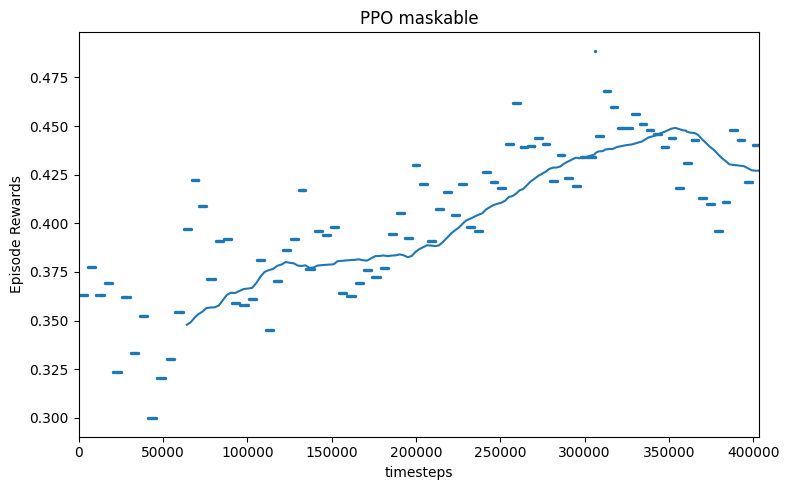

In [3]:
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)'
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)/'
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(400000)/'
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)/'
log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)_instanceID0/'

# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(350000)/'
# log_dir = f'./'
# Helper from the library
results_plotter.plot_results(
    [log_dir], 5e5, results_plotter.X_TIMESTEPS, "PPO maskable", (8, 5)
)

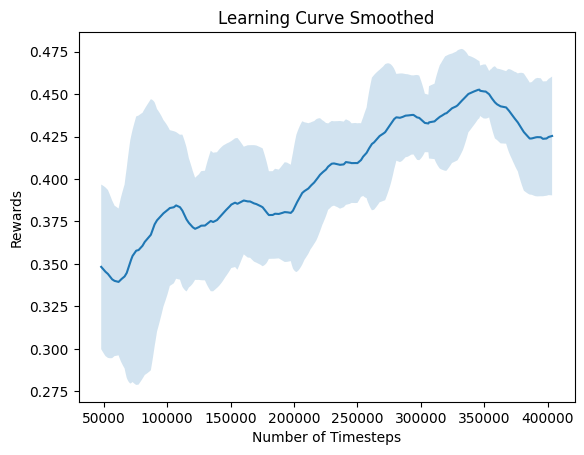

In [4]:
_ = plot_results(log_dir)
# _ = plot_results(log_dir2)

In [5]:
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(200000)/'
# log_dir2 = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)/'
# _ = plot_results(log_dir)
# _ = plot_results(log_dir2)
# plt.legend()

In [6]:
# log_dir2 = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(150000)/'
# _ = plot_results(log_dir2)
# plt.legend()

In [7]:
from numba import njit
@njit
def get_solution_single_type(k):
    #get an optimal solution with k omitted packages from a full dynamic table
    solution = np.zeros(k, dtype=np.int64)


    return solution

get_solution_single_type(3)

array([0, 0, 0])

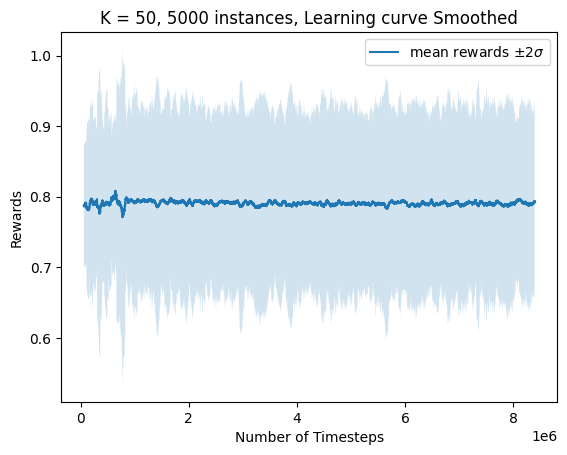

In [47]:
_ = plot_results('./', window=1000, title='K = 50, 5000 instances, Learning curve')
plt.legend()
plt
plt.savefig('long_run')

In [9]:
# import torch
# from torch import nn

# m = nn.Sigmoid()
# loss = nn.BCELoss(reduction='sum')
# input = torch.randn(1, 5, requires_grad=True)
# target = torch.rand(1, 5, requires_grad=False)
# output = loss(m(input), target)
# print(m(input))
# print(target.nelement())
# print(output)
# print(nn.MSELoss(reduction='sum')(m(input), target))

In [10]:
K = 100

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

A* evaluated 3672 different assignments
m = 85168
12596.0
max ommited: [25 25 25 25]
solution de taille 31 [ 0  2 23  6] valeur 117.0
[81  0 30 12 16 27 38 37 44 45 64 80 97 98 92 91 90 71 54 55 56 57 46 48
 61 96 89 79 95 99 94]


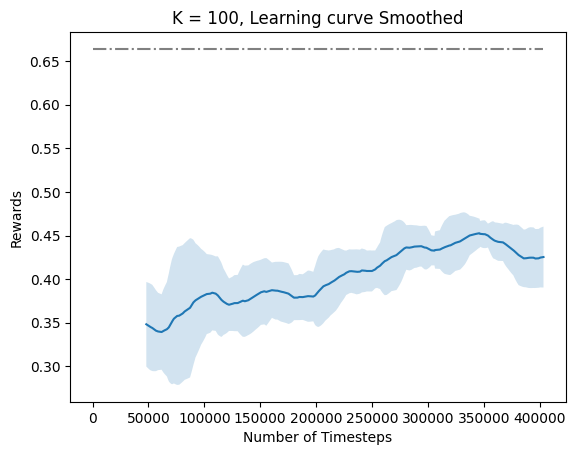

In [11]:
x = plot_results(log_dir, label='routes', title=f'K = {K}, Learning curve')#, show_hlines=True)
plt.hlines(r_opt, 0, x[-1], linestyles = '-.', label=f'A* = {round(r_opt, 4)}', colors='gray')

### K = 50

A* evaluated 495 different assignments
m = 85168
4104.0
trouve assez de packets avec le camion : 11 56.0
max ommited: [13 13 11 13]
solution de taille 11 [ 0  0 10  1] valeur 56.0
[ 8  0  4 19 43 31 25 11 33 36 34]


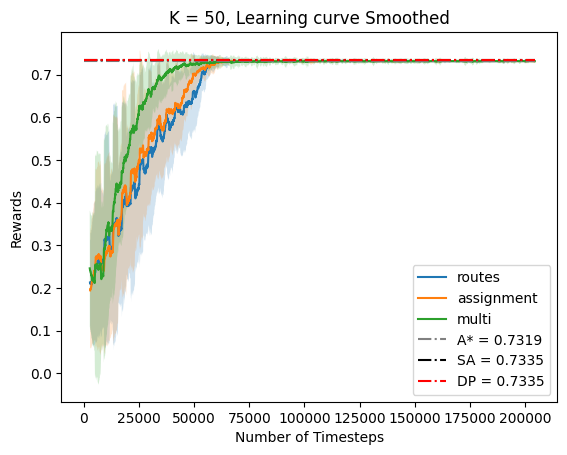

In [38]:
idx = 0
K = 50
steps = 200_000

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

tit = title=f'K = {K}, Learning curve'
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps(200000)_instanceID{idx}/', label='routes', title = tit)#, show_hlines=True)
# _ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(action)_steps(200000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(200000)_instanceID{idx}/', label='elimination gain', title = tit)#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(assignment)_steps(200000)_instanceID{idx}/', label='assignment', title = tit)#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(multi)_steps(200000)_instanceID{idx}/', label='multi', title = tit)#, show_hlines=True)

plt.hlines(r_A, 0, x[-1], linestyles = '-.', label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '-.', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], linestyles = '-.', label=f'DP = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('K50')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 100

In [39]:
idx = 0
K = 100
steps = 200_000

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

A* evaluated 3672 different assignments
m = 85168
12600.0
max ommited: [25 25 25 25]
solution de taille 31 [ 0  2 23  6] valeur 117.0
[81  0 30 12 16 27 38 37 44 45 64 80 97 98 92 91 90 71 54 55 56 57 46 48
 61 96 89 79 95 99 94]


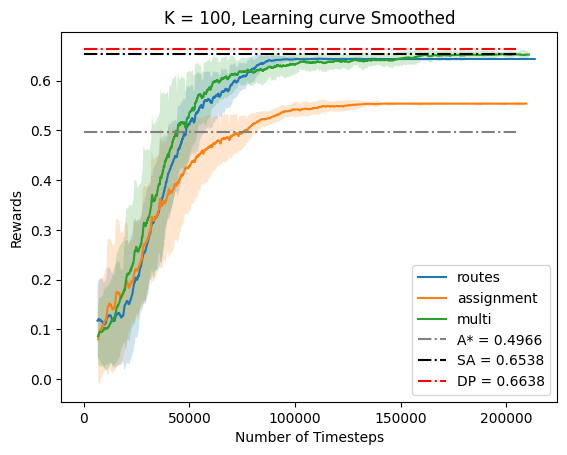

In [40]:
tit = title=f'K = {K}, Learning curve'

_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes', title=tit)#, show_hlines=True)
# x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps({steps})_instanceID{idx}/', label='elimination gain', title=tit)#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(assignment)_steps({steps})_instanceID{idx}/', label='assignment', title=tit)#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(multi)_steps({steps})_instanceID{idx}/', label='multi', title=tit)#, show_hlines=True)

plt.hlines(r_A, 0, x[-1], linestyles = '-.', label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '-.', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1],linestyles = '-.', label=f'DP = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('K100')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 1000

In [41]:
idx = 0
K = 1000
steps = 500_000

with open(f'game_K{K}_retain0.0.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}_retain0.0.npy')
dests = np.load(f'destinations_K{K}_retain0.0.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

A* evaluated 98644 different assignments
m = 85168
22778.0
trouve assez de packets avec le camion : 92 240.0
trouve assez de packets avec le camion : 109 239.0
max ommited: [200 200 200  92 109]
solution de taille 82 [ 0  1  0 30 51] valeur 243.0
[481 307 569 568 510 909 964 965 997 996 998 969 934 933 854 907 906 931
 960 961 962 957 958 959 956 815 502 501 472 471 470 860 890 913 911 806
 537 567 566 622 649 592 563 562 591 619 618 646 645 672 673 703 704 705
 733 764 797 824 825 826 799 766 765 763 796 795 762 761 732 731 760 793
 822 848 847 821 820 791 790 757 758 759]


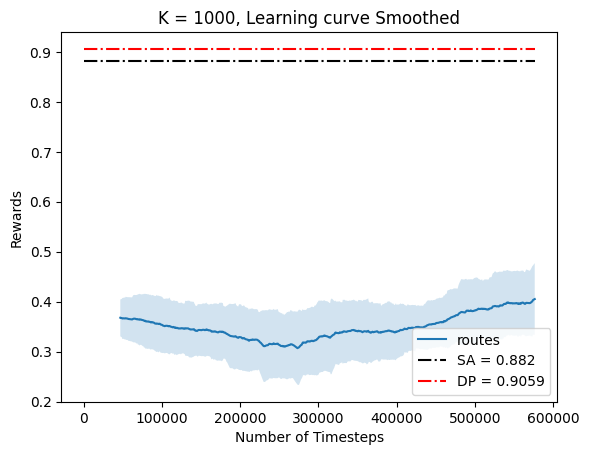

In [42]:
idx = 0
K = 1000
steps = 500_000
tit = title=f'K = {K}, Learning curve'

# x = plot_results(log_dir, label='routes')#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes', title=tit)#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(assignment)_steps(100000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
# x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(100000)_instanceID{idx}/', label='multi')#, show_hlines=True)

# plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '-.', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], linestyles = '-.', label=f'DP = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('K1000')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 250

In [43]:
idx = 0
K = 250
steps = 500_000

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = idx)
env.reset()
# res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
# action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
# o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

m = 85168
10631.0
max ommited: [50 50 50 50 50]
solution de taille 90 [ 0  1  1 49 39] valeur 261.0
[ 42  78 111 126 136 150 160 177 176 175 191 192 193 194 178 179 195 215
 214 204 213 225 239 240 226 241 242 227 228 229 216 217 230 243 218 219
 231 244 245 246 233 232 220 209 221 234 247 248 235 236 223  67  80  95
  81  82  70  68  69  56  57  71  72  58  45  34  33  32  20  21   9   8
   7   6  19  18   5   4   3  17  28  27  26  25  15   2   1   0  14  39]


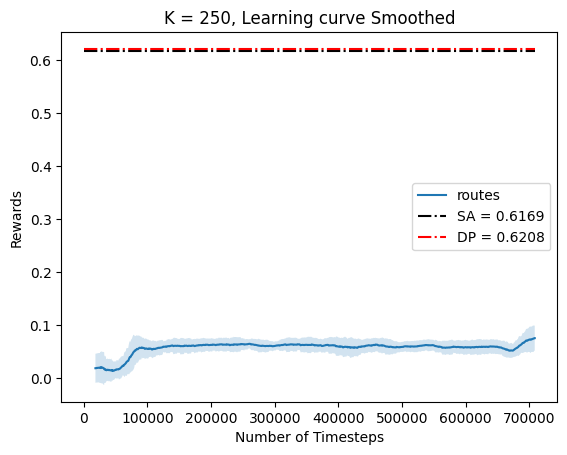

In [44]:
# x = plot_results(log_dir, label='routes')#, show_hlines=True)
# idx = 0
# steps = 500_000
# K = 250
tit = title=f'K = {K}, Learning curve'

x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes', title=tit)#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(assignment)_steps(100000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
# x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(100000)_instanceID{idx}/', label='multi')#, show_hlines=True)

# plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '-.', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], linestyles = '-.', label=f'DP = {round(r_opt, 4)}', colors='red')

plt.legend(loc='right')
plt.savefig('K250')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 400

In [45]:
idx = 0
K = 400
steps = 1_000_000

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
# res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
# action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
# o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

m = 85168
22555.0
max ommited: [80 80 80 80 80]
solution de taille 126 [ 0  0  0 46 80] valeur 335.0
[ 23  11 196 197 213 295 310 330 331 332 358 370 357 346 356 369 383 382
 368 355 328 329 345 309 294 163 164 165 166 149 130 129 113 112 111  92
  93  94  76  77  78  58  59  61  46  47  40  72  73  56  74  41  42  43
  27  26  14  13  25  24  12   0   1   2   3  28  29  45  44  60  80  79
  96  97 115 150 151 131 132 116 117 133 153 167 168 185 203 217 218 219
 204 186 169 170 187 205 220 234 233 252 251 232 250 249 231 216 201 202
 184 183 182 181 200 214 215 230 248 262 300 315 314 299 282 281 247 229]


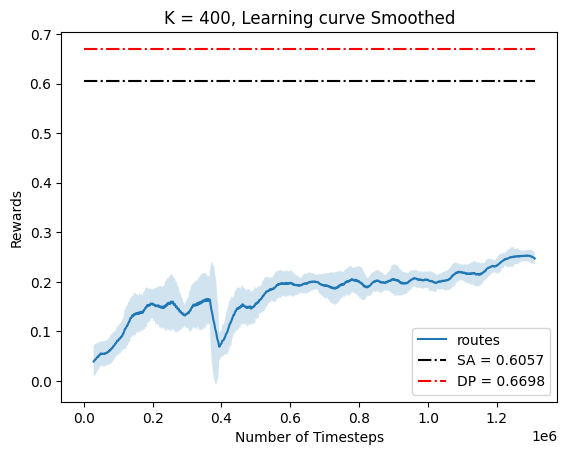

In [46]:
tit = title=f'K = {K}, Learning curve'
# x = plot_results(log_dir, label='routes')#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes', title=tit)#, show_hlines=True)
# _ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)_instanceID{idx}/', label='routes', title=tit)#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(assignment)_steps(100000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
# x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(100000)_instanceID{idx}/', label='multi')#, show_hlines=True)

# plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '-.', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], linestyles = '-.', label=f'DP = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('K400')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### Others

In [21]:
# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50000)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v0 : [2048, 2048, 1024, 256]')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51200)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v1 : [2048, 2048, 1024]')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51000)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v2 : [1024, 1024, 256, 128]')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51250)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v3 : [1024, 1024, 256, 128]', color='red')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# plt.legend()

In [22]:
# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50002)_instanceID0/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# col = 'red'
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='obs action', color=col)
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50001)_instanceID0/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# col = 'green'
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='obs normalized routes', color=col)
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50003)_instanceID0/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# col = 'purple'
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='obs routes', color=col)
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)

# plt.legend()